# Extended Kalman Filter

The **Extended Kalman Filter** (EKF) is a special Kalman filter used when at least one of the following conditions apply:

1) The system dynamics is not linear (e.g., orbit determination)
2) The observation model is not non linear (e.g., state is cartesian, tracking data are polar)

In case the equations to consider are the following:

--------------------------------------------------------------------------------------------- Prediction ----------------------------------------------------------------------------------
#### $$ \begin{matrix}
\mathbf{x}_{k+1}^P={\color{Red} f(t_k, \mathbf{x}_{k}, u_k)}\\
\mathbf{P}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{P}_{k}^P \mathbf{\Phi}_{t_k}^T + \mathbf{Q}_{k}\end{matrix}$$



---------------------------------------------------------------------------------------------- Update ------------------------------------------------------------------------------------
#### $$ \begin{matrix}
 \mathbf{K}_{k+1}=\mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T\left ( \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T + \mathbf{R}_{k+1} \right )^{-1} \\
 \mathbf{P}_{k+1}=\mathbf{P}_{k+1}^P - \mathbf{K}_{k+1} \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P \\
 \mathbf{x}_{k+1} = \mathbf{x}_{k+1}^P +\mathbf{K}_{k+1} \left ( \mathbf{y}_{k+1}-{\color{Red} g(t_{k+1}, \mathbf{x}_{k+1}^P)}\right )
\end{matrix}$$


The differences respect to the linear KF are the two (potentially) non-linear equations highlighted in red. The following considerations are applicable in this case:

- The predicted state estimate is evaluated using the non-linear dynamic model $\mathbf{f}$
- The state transition matrix $\mathbf{\Phi}$ is only used to propagate the state error covariance. Since it is a linear approximation of motion in the vicinity of the current state estimate, the addition of the process noise matrix $\mathbf{Q}$ is always needed
- During the measurement update phase, the expected value of the measurement is computed using the non-linear measurement model $\mathbf{g}$
- Because of this nonlinear relationship, the Kalman gain $\mathbf{K}$ and the state covariance matrix $\mathbf{P}$ are calculated using an $\mathbf{H}$ matrix which is different than that of a traditional Kalman Filter. Specifically, this is a **jacobian** matrix: it is made up of first order partial differential equations of the non-linear measurement model respect to the predicted state and is used to approximate nonlinear systems through a process called **linearization**: 

#### $$ \mathbf{H}_{k+1}= \frac{\partial g(t_{k+1}, \mathbf{x}_{k+1}^P)}{\partial \mathbf{x}_{k+1}^P} $$

Unlike its linear counterpart, the extended Kalman filter in general is not an optimal estimator (it is optimal if the measurement and the state transition model are both linear, as in that case the extended Kalman filter is identical to the regular one). In addition, if the initial estimate of the state is wrong, or if the process is modeled incorrectly (e.g., strong non-linearity), the filter may quickly diverge.

Another problem with the extended Kalman filter is that the estimated covariance matrix tends to underestimate the true covariance matrix and therefore risks becoming inconsistent in the statistical sense without the addition of "stabilising noise".

Finally, EKFs assume Gaussian noise, which might not hold in all real-world scenarios, leading to potential divergence if the noise is significantly non-Gaussian.


## Example - Ship Tracking

Problem Statement: Estimate the position and velocity of a ship travelling along a straight line with constant speed by processing range and azimuth observation taken from a radar located at the origin of the reference system.


<center><img src="Images/shipMotion.png" alt="Drawing" style="width: 700px;"/><center>


### Measurement Model
The tracking device is able to produce two different measurements (the range $r_m$ and the elevation $\theta_m$). Each measurement type has its own uncertainty, and the relevant covariance matrix is defined as a 2x2 diagonal matrix (no cross-correlation between measurement types). $t_m$ is the measurement time:

#### $$ \mathbf{y} = \begin{bmatrix}
r_m \\
\beta_m
\end{bmatrix} \quad \mathbf{R} = \begin{bmatrix}
\sigma_{r_m}^2  & 0\\
0 & \sigma_{\beta_m}^2
\end{bmatrix} \quad \quad t=t_m$$


The measurement to state relationship is nonlinear in this case (it involves a transformation between polar and cartesian coordinates):

#### $$ r = \sqrt {x^2 + y^2} \quad \beta=\arctan{\frac{y}{x}}$$


### System Model

At system level, we define the state vector and the state coveriance matrix as:
#### $$ \mathbf{x}=\begin{bmatrix}
x \\
y  \\
\dot{x}\\
\dot{y}\end{bmatrix}=  \quad \mathbf{P}=
\begin{bmatrix}
\sigma_x^2 & 0 & 0 & 0 \\
0 & \sigma_y^2 & 0 & 0 \\
0 & 0 & \dot{\sigma}_x^2 & 0 \\
0 & 0 & 0 & \dot{\sigma}_y^2 \\
\end{bmatrix}$$

The state update equation is written as:

#### $$ \begin{bmatrix}
x_{k+1} \\
y_{k+1}  \\
\dot{x}_{k+1} \\
\dot{y}_{k+1}\end{bmatrix}=\mathbf{\Phi}\begin{bmatrix}
x_k \\
y_k \\
\dot{x}_k \\
\dot{y}_k
\end{bmatrix}=
\begin{bmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}\begin{bmatrix}
x_k \\
y_k \\
\dot{x}_k \\
\dot{y}_k\end{bmatrix}= \begin{bmatrix}
x_k + \dot{x}_k \Delta t\\
y_k+ \dot{y}_k \Delta t\\
\dot{x} \\
\dot{y}
\end{bmatrix}$$

The process noise covariance matrix  defined as:

#### $$ \mathbf{Q}=s_d\begin{bmatrix}
\frac{1}{3}\Delta t^3 & 0 & \frac{1}{2}\Delta t^2 & 0 \\
0 & \frac{1}{3}\Delta t^3 & 0 &  \frac{1}{2}\Delta t^2\\
\frac{1}{2}\Delta t^2 & 0 & \Delta t & 0 \\
0 & \frac{1}{2}\Delta t^2 & 0 &  \Delta t\\
\end{bmatrix} $$

### Managing the non-linearity 

For this EKF example, the state to measurement relationship is nonlinear. Here is the applicable $\mathbf{H}$ matrix:

### $$ \mathbf{H}=\begin{bmatrix}
\frac{\partial r}{\partial x} & \frac{\partial r}{\partial y} & \frac{\partial r}{\partial \dot{x}} &  \frac{\partial r}{\partial \dot{y}}\\
\frac{\partial \theta}{\partial x} & \frac{\partial \theta}{\partial y} & \frac{\partial \theta}{\partial \dot{x}} & \frac{\partial \theta}{\partial \dot{y}} \\
\end{bmatrix} =\begin{bmatrix}
\frac{x}{r} & \frac{y}{r} & 0 &  0\\
\frac{-y}{r^2} & \frac{x}{r^2} & 0 & 0 \\
\end{bmatrix}$$

In [1]:
from estimation import *
%matplotlib widget

#####  model init conditions ######
x = 2900   # m
y = 1500   # m
xVel = -14.0  # m/sec
yVel = -10.0  # m/sec
###################################

########## meas model #############
nMeasurements = 101
sigmaBearing = 0.06  #
sigmaRange = 1       # m
###################################


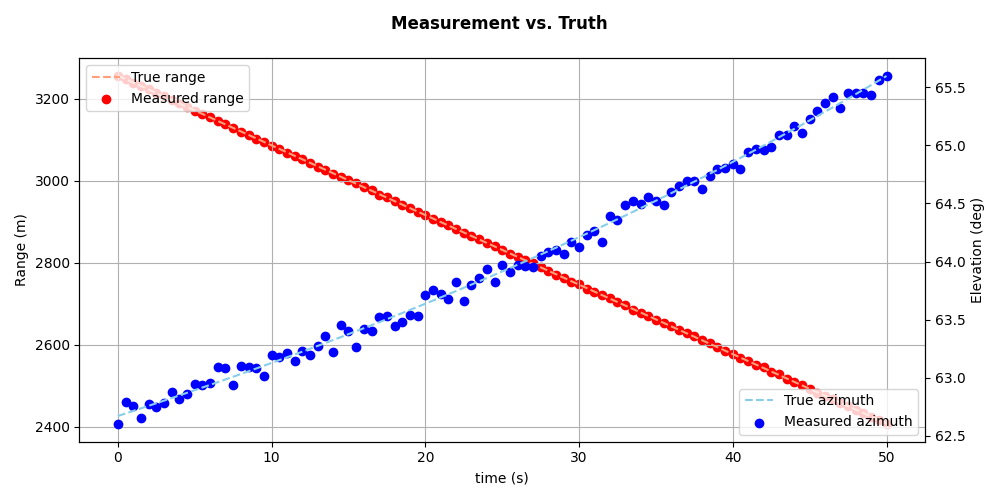

In [2]:
measTimes = np.linspace(0, 50, num=nMeasurements)
# Get delta T
dT = measTimes[1] - measTimes[0]

# Create storage arrays for true position data
xTrue = []
yTrue = []
rangeTrue = []
bearingTrue = []
# Compute the Real Position Data in cartesian and polar coordinates
for i in range(0,nMeasurements):  
    # Compute the new x and y position data
    x = x+dT*xVel
    y = y+dT*yVel
    # Store the computed data
    xTrue.append(x)
    yTrue.append(y)
    rangeTrue.append(np.sqrt(x*x + y*y))
    bearingTrue.append(np.arctan2(x, y) * 180/np.pi)

# Create storage containers for polar measurement data
rangeMeas = []
bearingMeas = []
covMeas = []

# Storage containers for cartesian measurements - for analysis purposes
m_x = []
m_y = []
for i in range(0, len(measTimes)):
    bearingMeas.append(bearingTrue[i] + sigmaBearing * np.random.randn())
    rangeMeas.append(rangeTrue[i] + sigmaRange * np.random.randn())
    covMeas.append(np.array([[sigmaRange*sigmaRange, 0], [0, sigmaBearing*sigmaBearing]]))
z=[rangeMeas, bearingMeas, covMeas, rangeTrue, bearingTrue, measTimes, xTrue, yTrue]

plot1, ax1 = plt.subplots()
plt.title('Measurement vs. Truth \n', fontweight="bold")
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Range (m)')
ax1.plot(z[5], z[3], color='lightsalmon', linestyle='--', label='True range')
ax1.scatter(z[5], z[0], color ='red', label='Measured range')
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('Elevation (deg)')  # we already handled the x-label with ax1
ax2.plot(z[5], z[4], color='skyblue', linestyle='--', label='True azimuth')
ax2.scatter(z[5], z[1], color ='blue', label='Measured azimuth')
ax2.tick_params(axis='y')
ax2.legend(loc = 'lower right')
plot1.set_size_inches(10,5)
plot1.tight_layout()

In [3]:
from estimation import *
%matplotlib widget

#### initial state uncertainty ####
xUnc  = 20 # m
yUnc  = 40 # m
vxUnc = 15 # m/s
vyUnc = 15  # m/s
###################################


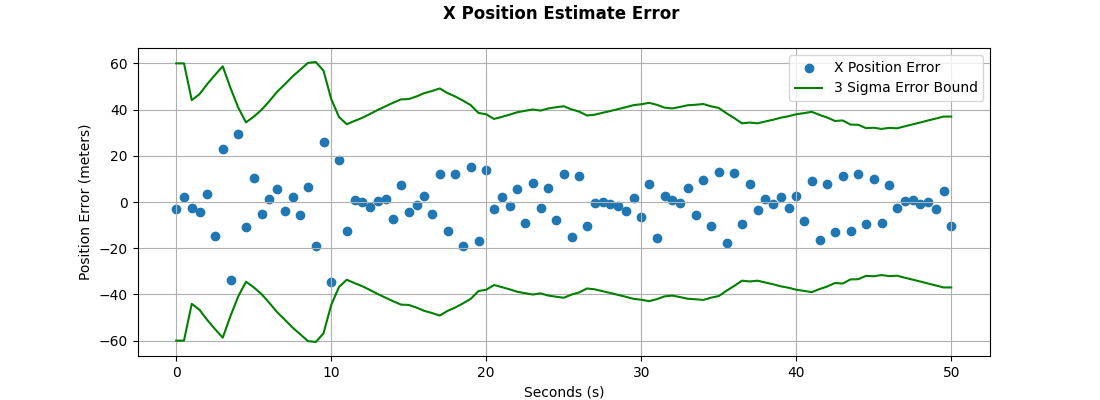

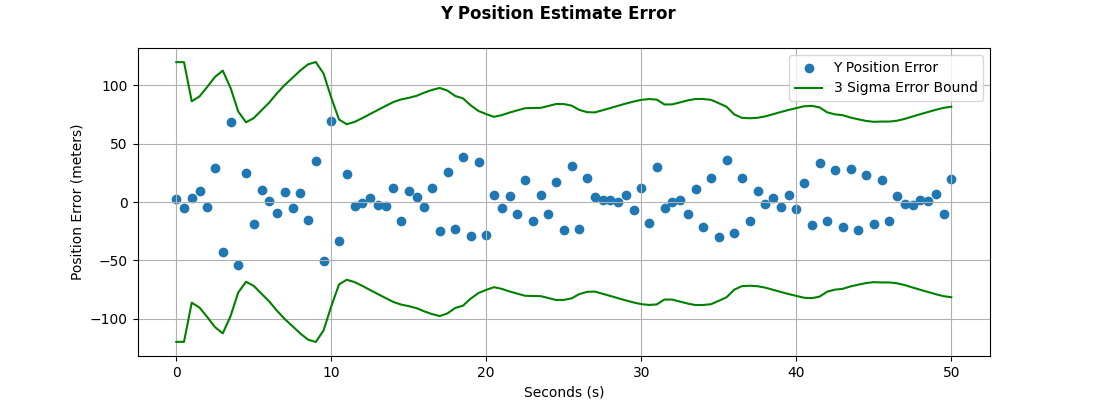

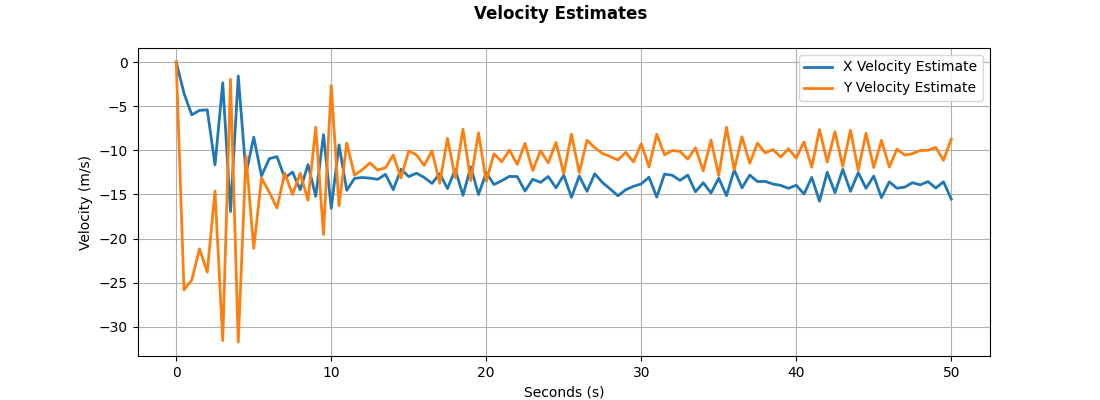

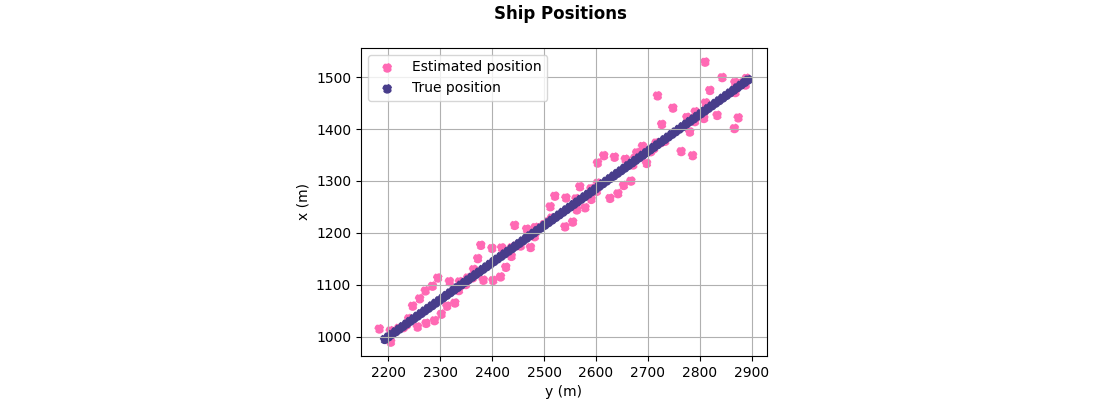

In [4]:
f_x = []
f_y = []
f_x_sig = []
f_y_sig =[]
f_xv = []
f_yv = []
f_xv_sig = []
f_yv_sig =[]

for i in range(0, len(z[0])):
  f = ekfilter(z, i, dT, xUnc, yUnc, vxUnc, vyUnc)
  f_x.append(f[0])
  f_y.append(f[1])
  f_xv.append(f[3])
  f_yv.append(f[4])
  f_x_sig.append(np.sqrt(f[2][0][0]))
  f_y_sig.append(np.sqrt(f[2][1][1]))

# Compute Range Error
e_x_err = []
e_x_3sig = []
e_x_3sig_neg = []
e_y_err = []
e_y_3sig = []
e_y_3sig_neg = []
for m in range(0, len(z[0])):
    e_x_err.append(f_x[m]-z[6][m])
    e_x_3sig.append(3*f_x_sig[m])
    e_x_3sig_neg.append(-3*f_x_sig[m])
    e_y_err.append(f_y[m]-z[7][m])
    e_y_3sig.append(3*f_y_sig[m])
    e_y_3sig_neg.append(-3*f_y_sig[m])


fig1 = plt.figure(figsize=(11,4))
plt.grid(True)
line1 = plt.scatter(z[5], e_x_err)
line2, = plt.plot(z[5], e_x_3sig, color='green')
plt.plot(z[5], e_x_3sig_neg, color='green')
plt.ylabel('Position Error (meters)')
plt.xlabel('Seconds (s)')
plt.title('X Position Estimate Error \n', fontweight="bold")
plt.legend([line1, line2,], ['X Position Error', '3 Sigma Error Bound'])
plt.show()

fig2 = plt.figure(figsize=(11,4))
plt.grid(True)
yline1 = plt.scatter(z[5], e_y_err)
yline2, = plt.plot(z[5], e_y_3sig, color='green')
plt.plot(z[5], e_y_3sig_neg, color='green')
plt.ylabel('Position Error (meters)')
plt.xlabel('Seconds (s)')
plt.title('Y Position Estimate Error  \n', fontweight="bold")
plt.legend([yline1, yline2,], ['Y Position Error', '3 Sigma Error Bound'])
plt.show()

fig3 = plt.figure(figsize=(11,4))
plt.grid(True)
plt.plot(z[5], f_xv, linewidth=2)
plt.plot(z[5], f_yv, linewidth=2)
plt.title('Velocity Estimates \n', fontweight="bold")
plt.legend(['X Velocity Estimate', 'Y Velocity Estimate'])
plt.ylabel('Velocity (m/s)')
plt.xlabel('Seconds (s)')
plt.show()

fig4 = plt.figure(figsize=(11,4))
plt.grid(True)
plt.scatter(f_x, f_y, color='hotpink', linestyle='--', label='Estimated position')
plt.scatter(z[6], z[7], color='darkslateblue', linestyle='--', label='True position')
plt.ylabel('x (m)')
plt.xlabel('y (m)')
plt.title('Ship Positions \n', fontweight="bold")
plt.gca().set_aspect('equal') 
plt.legend()
plt.show()